<a href="https://colab.research.google.com/github/tinkercademy/ml-notebooks/blob/main/Machine Learning in Pytorch/02_Computer_Vision_with_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beyond Hello World, A Computer Vision Example
In the previous exercise you saw how to create a neural network that figured out the problem you were trying to solve. This gave an explicit example of learned behavior. Of course, in that instance, it was a bit of overkill because it would have been easier to write the function Y=3x+1 directly, instead of bothering with using Machine Learning to learn the relationship between X and Y for a fixed set of values, and extending that for all values.

But what about a scenario where writing rules like that is much more difficult -- for example a computer vision problem? Let's take a look at a scenario where we can recognize different items of clothing, trained from a dataset containing 10 different types.

## Start Coding

Let's start with our import of PyTorch

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We will train a neural network to recognize items of clothing from a common dataset called Fashion MNIST. You can learn more about this dataset [here](https://github.com/zalandoresearch/fashion-mnist).

It contains 70,000 items of clothing in 10 different categories. Each item of clothing is in a 28x28 greyscale image. You can see some examples here:

![alt text](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

The Fashion MNIST data is available directly in the torchvision datasets API. You load it like this:

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

We create a mapping between the labels and its text description.

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

We can train a couple of the training samples and visualise it.

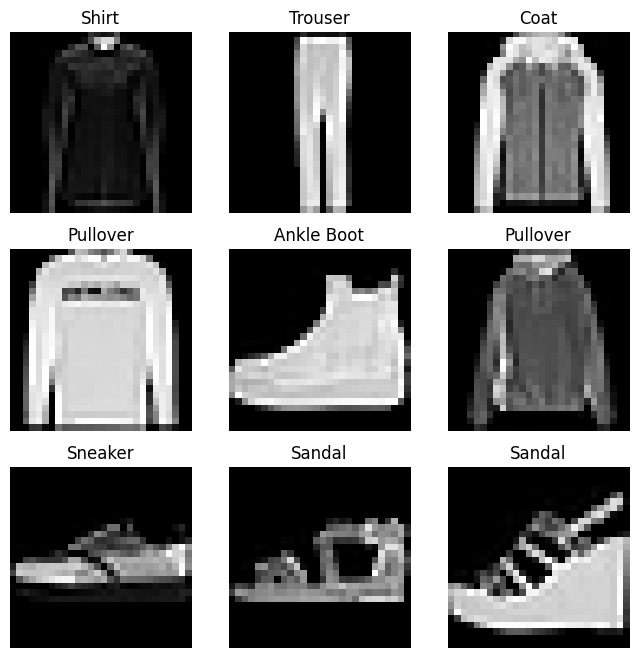

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Now you might be wondering why there are 2 sets...training and testing -- remember we spoke about this in the intro? The idea is to have 1 set of data for training, and then another set of data...that the model hasn't yet seen...to see how good it would be at classifying values. After all, when you're done, you're going to want to try it out with data that it hadn't previously seen!

## Model Design

Let's now design the model.

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64,10)
        #defining the 20% dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        #not using dropout on output layer
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

## Training

zero_grad():Clear the gradients of all optimized variables

log_ps = model(images): Make a forward pass through the network to getting log probabilities bypassing the images to the model.

loss = criterion(log_ps, lables):Use the log probabilities (log_ps) and labels to calculate the loss.

loss.backward():Perform a backward pass through the network to calculate the gradients for model parameters.

optimizer.step()Take a step with the optimizer to update the model parameters.

In [ ]:
model = Classifier ()
#defining the loss function
criterion = nn.NLLLoss() # negative log likelihood loss
optimizer = optim.SGD(model.parameters(), lr=0.01) #stochastic gradient descent

test_loss_min = np.Inf #using this high value to make sure the update the weight first time
epochs = 40
model.train() #prep model for training
train_losses, test_losses = [], []
for e in range(epochs):
    train_loss =0
    test_loss = 0
    # train the model #
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    for images, labels in test_dataloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        test_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_dataloader.sampler)
    test_loss = test_loss/len(test_dataloader.sampler)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print('Epoch: {} \Training Loss: {:.6f} \tTest Loss: {:.6f}'.format(
            e+1,
            train_loss,
            test_loss,
    ))
    
    if test_loss <= test_loss_min:
        print("test loss decreased({:.6f} --›{:.6f}). Saving Model ...".format(test_loss_min, test_loss))
        torch. save (model.state_dict (), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 \Training Loss: 1.917879 	Test Loss: 1.266169
test loss decreased(inf --›1.266169). Saving Model ...
Epoch: 2 \Training Loss: 1.066459 	Test Loss: 0.940081
test loss decreased(1.266169 --›0.940081). Saving Model ...
Epoch: 3 \Training Loss: 0.844699 	Test Loss: 0.798922
test loss decreased(0.940081 --›0.798922). Saving Model ...
Epoch: 4 \Training Loss: 0.727777 	Test Loss: 0.703534
test loss decreased(0.798922 --›0.703534). Saving Model ...
Epoch: 5 \Training Loss: 0.652892 	Test Loss: 0.649135
test loss decreased(0.703534 --›0.649135). Saving Model ...
Epoch: 6 \Training Loss: 0.604596 	Test Loss: 0.607738
test loss decreased(0.649135 --›0.607738). Saving Model ...
Epoch: 7 \Training Loss: 0.563326 	Test Loss: 0.570763
test loss decreased(0.607738 --›0.570763). Saving Model ...
Epoch: 8 \Training Loss: 0.535115 	Test Loss: 0.551878
test loss decreased(0.570763 --›0.551878). Saving Model ...
Epoch: 9 \Training Loss: 0.509633 	Test Loss: 0.534627
test loss decreased(0.551878 -

# Plot the losses

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Losss")
plt.legend()

### Visualising a trained model

In [ ]:
# obtain one batch of test images
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# get sample outputs
output = model (images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))